# Hiding Information in AI Explanations - Project Code.
Author: Zofia Zubrzycka

The code consists of few parts. Part I sets up the environment and is necessary to be run for the other parts to work. Part II represents the GUI and part III is an optional saliency map check.

## Running the code, part I - setting the environment
The only variable that needs to be changed by you in order to be able to run the code is the folder_path, which represents the folder of the cloned repository (and maybe also the font path in the image_from_text() function).
After that, an outside github repository needs to be cloned. Then few files need to be changed to my own versions of them. Then, the requirements are installed. The last cell in this part consists of all the imports and functions that are used in the GUI.

In [1]:
!git clone https://github.com/pankessel/adv_explanation_ref.git

Cloning into 'adv_explanation_ref'...


In [43]:
folder_path = "C:/users/julien/rai/adv_explanation_ref/"

In [3]:
import requests

url = "https://raw.githubusercontent.com/zzubrzycka/ResponsibleAI_project/1bec48256f838878de18c578d266121dc67f36e5/run_attack.py"
save_path = "adv_explanation_ref/src/run_attack.py"

url2 = "https://raw.githubusercontent.com/zzubrzycka/ResponsibleAI_project/1bec48256f838878de18c578d266121dc67f36e5/requirements.txt"
save_path2 = "adv_explanation_ref/requirements.txt"
r = requests.get(url)
with open(save_path, "wb") as f:
    f.write(r.content)
r = requests.get(url2)
with open(save_path2, "wb") as f:
    f.write(r.content)


In [19]:
cd adv_explanation_ref

[WinError 2] The system cannot find the file specified: 'adv_explanation_ref'
C:\Users\Julien\rai\adv_explanation_ref


C:\Users\Julien\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [5]:
 pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu126Note: you may need to restart the kernel to use updated packages.



In [44]:
import os
import shutil
import subprocess
import requests
from io import BytesIO

import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torchvision.models import resnet50
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM

from pathlib import Path
import sys
sys.path.append(str(Path().resolve() / "src"))

from nn.utils import get_expl, load_image
from nn.enums import ExplainingMethod
from nn.networks import ExplainableNet
import torchvision.models as models

imagenet_classes = requests.get("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt").text.splitlines()

model = models.resnet34(pretrained=True)
model.eval()

model_gradcam = models.resnet34(pretrained=True)
model_gradcam.eval()
cam_extractor = GradCAM(model_gradcam, target_layer=model_gradcam.layer4[-1])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


#input image and an image made from text undergo this
def preprocess_image(input_image, output_path):

    image_rgb = input_image.convert("RGB")
    image_rgb.save(output_path, format="PNG")

    return Image.open(output_path)


#made for classyfying the image and returning its probability
def classify(image):

    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        top_prob, top_class = probs.topk(1, dim=1)

    class_name = imagenet_classes[top_class.item()]
    probability = top_prob.item()
    return class_name, probability


#helper functions for creating an image from text, they manage situations in which the word is very
#long or there are few words or when in general the whole string is too long and doesnt fit in the image
def text_size(draw, text, font):
    bbox = draw.textbbox((0, 0), text, font=font)
    width = bbox[2] - bbox[0]
    height = bbox[3] - bbox[1]
    return width, height

def split_long_word(word, font, max_width, draw):
    parts = []
    part = ""
    for char in word:
        test = part + char
        w, _ = text_size(draw, test, font)
        if w > max_width:
            if part:
                parts.append(part)
            part = char
        else:
            part = test
    if part:
        parts.append(part)
    return parts

def wrap_text_to_fit(text, font, max_width, draw):
    words = text.split()
    lines = []
    current_line = ""

    for word in words:
        test_line = (current_line + " " + word).strip()
        w, _ = text_size(draw, test_line, font)
        if w <= max_width:
            current_line = test_line
        else:
            if current_line:
                lines.append(current_line)

            w_word, _ = text_size(draw, word, font)
            if w_word <= max_width:
                current_line = word
            else:
                split_parts = split_long_word(word, font, max_width, draw)
                for i, part in enumerate(split_parts):
                    if i == 0:
                        current_line = part
                    else:
                        lines.append(current_line)
                        current_line = part
    if current_line:
        lines.append(current_line)

    return lines

def find_max_font_and_wrapped(text, image_size, font_path, max_font_size=500, min_font_size=20):
    img = Image.new('L', image_size)
    draw = ImageDraw.Draw(img)
    width, height = image_size

    for font_size in reversed(range(min_font_size, max_font_size + 1, 2)):
        font = ImageFont.truetype(font_path, font_size)

        w, h = text_size(draw, text, font)
        if w <= width and h <= height:
            return font, [text]
        font = ImageFont.truetype(font_path, min_font_size)
    lines = wrap_text_to_fit(text, font, width, draw)

    line_height = text_size(draw, "Ay", font)[1] + 4
    max_lines = height // line_height

    if len(lines) > max_lines:
        lines = lines[:max_lines]

        if lines:
            last_line = lines[-1]
            ellipsis = "…"
            while text_size(draw, last_line + ellipsis, font)[0] > width and last_line:
                last_line = last_line[:-1]
            lines[-1] = last_line + ellipsis

    return font, lines



#main function for creating the image from text based on previous ones
def image_from_text(text, width, height):
    font_path = "C:/Windows/Fonts/georgia.ttf"
    image_size = (width, height)
    font, lines = find_max_font_and_wrapped(text, image_size, font_path)

    img = Image.new('L', image_size, color=0)
    draw = ImageDraw.Draw(img)

    line_height = text_size(draw, "Ay", font)[1] + 4
    total_text_height = line_height * len(lines)
    y = (height - total_text_height) // 2

    for line in lines:
        w, _ = text_size(draw, line, font)
        x = (width - w) // 2
        draw.text((x, y), line, font=font, fill=255)
        y += line_height

    return img



#my try of the gradcam method, its not used in the code, but i wanted to include it
def saliency_map_gen(input_image, model=model_gradcam, device="cuda"):
    model = model.to(device)


    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])


    if isinstance(input_image, Image.Image):
        x = preprocess(input_image).unsqueeze(0).to(device)
    elif isinstance(input_image, torch.Tensor):
        x = input_image.clone().detach().to(device)
        if x.dim() == 3:
            x = x.unsqueeze(0)
    else:
        raise ValueError("Unsupported input type for saliency_map_gen")

    x.requires_grad = True

    output = model(x)
    class_idx = output.argmax(dim=1).item()
    score = output[0, class_idx]
    score.backward()

    saliency = x.grad * x
    saliency = saliency.abs().sum(dim=1, keepdim=True)
    saliency = saliency - saliency.min()
    saliency = saliency / (saliency.sum() + 1e-8)
    saliency = F.interpolate(saliency, size=(224, 224), mode='bilinear', align_corners=False)

    return saliency.detach()



#lrp method
def get_lrp_map(image_path, model=None, device=None, folder_path=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    #ImageNet normalisation
    data_mean = [0.485, 0.456, 0.406]
    data_std = [0.229, 0.224, 0.225]

    full_path = Path(os.path.join(folder_path, image_path)) if folder_path else Path(image_path)
    x = load_image(data_mean, data_std, device, full_path)

    if model is None:
        base_model = models.vgg16(pretrained=True)
        model = ExplainableNet(model=base_model).eval().to(device)

    expl_map, _, _ = get_expl(model, x, ExplainingMethod.lrp)

    return expl_map.squeeze(0).detach()


#connecting everything to one function
def run(input_image, text_to_encode):

    #creating a tuple so each output in gradio can be shown after its done and not that everything is shown together at the end
    outputs = [None]*8
    yield tuple(outputs)

    #cleaning the temporary files
    temp_folder_path = os.path.join(folder_path, "temp/")

    if os.path.exists(temp_folder_path):
        shutil.rmtree(temp_folder_path)

    os.makedirs(temp_folder_path)


    #taking care of the original input image
    temp_path_input_image = os.path.join(folder_path, "temp/temp_input_image.png")
    preprocessed_input_image = preprocess_image(input_image, temp_path_input_image)


    #taking care of the text
    width,height = input_image.size
    text_image = image_from_text(text_to_encode, width, height)
    temp_path_text_image = os.path.join(folder_path, "temp/temp_text_image.png")
    preprocessed_text_image = preprocess_image(text_image, temp_path_text_image)

    #checking the original classification and its probability
    print("checking the original class and probability...")
    original_class, original_probability = classify(preprocessed_input_image)
    outputs[0] = original_class
    outputs[1] = original_probability
    yield tuple(outputs)


    #running the outside script
    python_file_folder_path = os.path.join(folder_path, "src/")
    model_path = os.path.join(folder_path, 'models/model_vgg16_pattern_small.pth')
    outputs_path = os.path.join(folder_path, "output/")
    print("running the script...")
    subprocess.run(["python", "run_attack.py", "--cuda", "--img", temp_path_input_image, "--target_img", temp_path_text_image, '--output_dir', outputs_path, '--model_path', model_path], cwd=python_file_folder_path)


    #ccopying all the images to the temporary folder
    print("copying the images...")
    images = {}
    for i in ["manipulated_image.png", "original_expl.png", "target_expl.png", "manipulated_expl.png"]:
        shutil.copy(os.path.join(folder_path, f"output/{i}"), os.path.join(folder_path, f"temp/temp_{i}"))
        key = i.replace(".png", "")
        images[key] = Image.open(os.path.join(folder_path, f"temp/temp_{i}"))

    outputs[2] = images["original_expl"]
    outputs[3] = images["target_expl"]
    outputs[4] = images["manipulated_expl"]
    outputs[5] = images["manipulated_image"]
    yield tuple(outputs)

    original_expl = images["original_expl"]
    target_expl = images["target_expl"]
    manipulated_expl = images["manipulated_expl"]
    manipulated_image = images["manipulated_image"]

    #checking the new classification and its probability
    new_class, new_probability = classify(manipulated_image)
    outputs[6] = new_class
    outputs[7] = new_probability
    yield tuple(outputs)
    

   # return original_class, original_probability, original_expl, target_expl, manipulated_expl, manipulated_image, new_class, new_probability

## Running the code, part II - gradio GUI
Here, the GUI can be run and used by the user (after running all the previous cells in part I).

In [7]:
import gradio as gr

with gr.Blocks(title="Hiding information in AI explanations", css="""
    .results-container {
        background-color: #f0f0f0 !important;
        padding: 15px !important;
        border-radius: 8px !important;
        border: 1px solid #ddd !important;
    }
""") as demo:
    gr.Markdown("# Hiding information in AI explanations")
    gr.Markdown("Here you can upload a picture of your choice and choose the text that should be displayed in the explanation of its classification.")

    with gr.Row():
        # Left column
        with gr.Column(scale=1):
            gr.Markdown("### Inputs")
            input_image = gr.Image(type="pil", label="Upload Image")
            input_text = gr.Textbox(label="Text Input")
            submit_btn = gr.Button("Process", variant="primary")

        with gr.Column(scale=3, elem_classes=["results-container"]):
            gr.Markdown("### Results")

            with gr.Row():
                with gr.Column():
                    output_text1 = gr.Textbox(label="Original Classification", interactive=False)
                    output_text2 = gr.Textbox(label="Original Probability", interactive=False)

                original_saliency = gr.Image(type="pil", label="Original Explanation", interactive=False)
                text_saliency = gr.Image(type="pil", label="Target Explanation", interactive=False)

            with gr.Row():
                with gr.Column():
                    output_text3 = gr.Textbox(label="New Classification", interactive=False)
                    output_text4 = gr.Textbox(label="New Probability", interactive=False)

                reconstructed_image = gr.Image(type="pil", label="Manipulated Image", interactive=False)
                manipulated_saliency = gr.Image(type="pil", label="Manipulated Explanation", interactive=False)

    submit_btn.click(
        fn=run,
        inputs=[input_image, input_text],
        outputs=[output_text1, output_text2, original_saliency, text_saliency,
                manipulated_saliency, reconstructed_image, output_text3, output_text4]
    )

demo.launch(debug=True, show_api=False)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


## Running the code part III - checking the maniplauted image explanation
This part is optional, it was made only for checking if the explanation of the manipulated image actually looks like the target explanation. So the generated manipulated image is run through a function that creates a saliency map with the LRP algorithm. This part also can be run only after running all the cells in part I and the image_path variable needs to be changed.

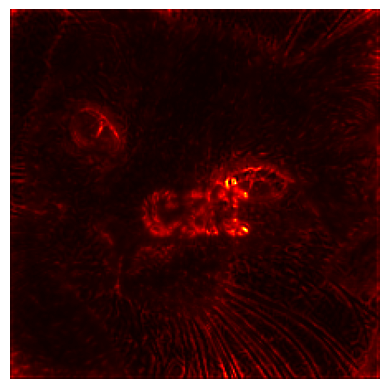

In [21]:
#manipulated image explanation can be tested here
%matplotlib inline

image_path = os.path.join(folder_path, "temp/temp_manipulated_image.png")

lrp_map = get_lrp_map(image_path, device="cuda")
plt.imshow(lrp_map.cpu().numpy(), cmap="hot")
plt.axis("off")
plt.show()



## My attempt for manipulation algorithm

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

def load_image2(path):
    image = Image.open(path).convert('RGB')
    return transform(image).unsqueeze(0).to(device)

source_path = os.path.join(folder_path, "data/temp_input_image.png")
target_path = os.path.join(folder_path, "data/temp_text_image.png")

x_source = load_image2(source_path)
x_target = load_image2(target_path)

from nn.networks import ExplainableNet
from nn.utils import get_expl, ExplainingMethod


vgg_model = models.vgg16(pretrained=True)
model = ExplainableNet(vgg_model).eval().to(device)

def simple_lrp(model, x):
    expl_map, _, _ = get_expl(model, x, method=ExplainingMethod.lrp)
    return expl_map


In [52]:
def manipulate_image(model, x_source, h_target, explanation_fn, gamma=1e-3,
                     steps=1000, lr=1e-2, clamp=(0, 1)):

    x_adv = x_source.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([x_adv], lr=lr)

    with torch.no_grad():
        g_orig = model(x_source)

    for step in range(steps):
        optimizer.zero_grad()

        h_adv = explanation_fn(model, x_adv)
        sal_loss = F.mse_loss(h_adv, h_target)

        g_adv = model(x_adv)
        class_loss = F.mse_loss(g_adv, g_orig)

        loss = sal_loss + gamma * class_loss
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            x_adv.clamp_(*clamp)

        if step % 100 == 0:
            print(f"[{step}] Loss={loss.item():.4e} | Sal={sal_loss.item():.4e} | Class={class_loss.item():.4e}")

    return x_adv.detach()

with torch.no_grad():
    h_target = get_lrp_map(target_path, model=model, device=device)
    h_source = get_lrp_map(source_path, model=model, device=device)



In [53]:
x_adv = manipulate_image(model, x_source, h_target, simple_lrp, gamma=1e-2, steps=1000, lr=5e-2)


C:\Users\Julien\AppData\Local\Temp\ipykernel_10332\3661950504.py:14: UserWarning: Using a target size (torch.Size([224, 224])) that is different to the input size (torch.Size([1, 224, 224])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  sal_loss = F.mse_loss(h_adv, h_target)


[0] Loss=4.1023e-09 | Sal=4.1023e-09 | Class=0.0000e+00


KeyboardInterrupt: 

In [ ]:
def show(img_tensor, title=""):
    img = img_tensor.squeeze().detach().cpu().numpy()
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
    elif img.shape[0] == 1:
        img = img[0]
    plt.imshow(img, cmap='viridis')
    plt.axis('off')
    plt.title(title)
    plt.show()

h_adv = simple_lrp(model, x_adv)

show(x_source, "Source Image")
show(x_target, "Target Image")
show(x_adv, "Manipulated Image")

show(h_source, "Source Saliency")
show(h_target, "Target Saliency")
show(h_adv, "Manipulated Saliency")


In [ ]:
#!python C:\users\julien\rai_project_LOCAL\adv_explanation_ref\src\run_attack.py --cuda